# Analysing T1 data taken with various methods 

In [2]:
import json
import csv
import scipy as scp
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

C:\Users\awschlab\AppData\Local\Temp\ipykernel_23940\1283944295.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
###################### Exponential fitting function ######################

def expfit(x, a, b, c):
    
    return ((a * np.exp(-x * b)) + c)

##########################################################################

In [79]:
############## Calculating M_measured for two-measurement T1 ##############

def two_meas(S_0_0_0_mean, S_level_0_0_mean, S_level_0_tau_mean, S_0_0_tau_mean, \
             S_0_0_0_err, S_level_0_0_err, S_level_0_tau_err, S_0_0_tau_err):
    
    top = S_0_0_tau_mean - S_level_0_tau_mean
    bottom = S_0_0_0_mean - S_level_0_0_mean
    top_err = (S_0_0_tau_err ** 2 + S_level_0_tau_err ** 2) ** 0.5
    bottom_err = (S_0_0_0_err ** 2 + S_level_0_0_err ** 2) ** 0.5

    ratio = bottom / (bottom_err * bottom_err)
    relative = bottom_err / bottom
    z0 = 0.25 * ratio * ((1 + (8 * relative * relative) ** 0.5) - 1)
    z02 = z0*z0 
    eA02 = bottom_err * bottom_err    
    dL2dz2 = (2 * ratio / (z02 * z0)) + (2 / z02) - (3 / (eA02 * z02 * z02))
    ez0 = 1 / ((-dL2dz2) ** 0.5)
    inv_bottom = z0
    inv_bottom_err = ez0

    z = top * inv_bottom
    z_err = ((top * inv_bottom_err)**2 + (inv_bottom_err * top_err) ** 2) ** 0.5
    
    return z, z_err

##############################################################################

## Regular T1

This is a standard decay measurement. The laser is turned on for some time exciting the NV, laser turns off for time tau, and then the emitted photons are counted. Sweeping over taus gives an exponential decay.

In [15]:
regular_t1_plus = pd.read_csv('mwt1_2.914GHz_6dBm_30ns_laser2_2ms.csv')
regular_t1_minus = pd.read_csv('mwt1_2.828GHz_6dBm_60ns_laser2_5ms.csv')

regular_tau_plus = regular_t1_plus['Bright Counts_x'].to_numpy()
bright_counts_plus = regular_t1_plus['Bright Counts_y'].to_numpy()
dark_counts_plus = regular_t1_plus['Dark Counts_y'].to_numpy()
diff_plus = (bright_counts_plus - dark_counts_plus) #/ (bright_counts + dark_counts)

regular_tau_minus = regular_t1_minus['Bright Counts_x'].to_numpy()
bright_counts_minus = regular_t1_minus['Bright Counts_y'].to_numpy()
dark_counts_minus = regular_t1_minus['Dark Counts_y'].to_numpy()
diff_minus = (bright_counts_minus - dark_counts_minus) #/ (bright_counts + dark_counts)

p0_plus = [diff_plus[0], 1, 1]
popt_plus, pcov_plus = scp.optimize.curve_fit(expfit, regular_tau_plus, diff_plus, p0_plus)

p0_minus = [diff_minus[0], 1, 1]
popt_minus, pcov_minus = scp.optimize.curve_fit(expfit, regular_tau_minus, diff_minus, p0_minus)

T1_Plus_regular = 1 / popt_plus[1]
T1_Minus_regular = 1 / popt_minus[1]
Gamma_Plus_regular = popt_plus[1] * 1000
Gamma_Minus_regular = popt_minus[1] * 1000

print('T1_Plus (us): ', T1_Plus_regular, ' Gamma_Plus (ms^-1): ', Gamma_Plus_regular)
print('T1_Minus (us): ', T1_Minus_regular, ' Gamma_Minus (ms^-1): ', Gamma_Minus_regular)
    
fit_plus = expfit(tau_plus, popt_plus[0], popt_plus[1], popt_plus[2])
fit_minus = expfit(tau_minus, popt_minus[0], popt_minus[1], popt_minus[2])

plt.subplot(221)
plt.plot(regular_tau_plus / 1000, bright_counts_plus / 1000, 'o-', color="blue", label='bright_counts')
plt.plot(regular_tau_plus /1000, dark_counts_plus / 1000, 'o-', color="green", label='dark_counts')
plt.xlabel('tau (ms)')
plt.ylabel('PL (kcps)')
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(regular_tau_plus / 1000, diff_plus / 1000, 'o-', color="black", label='diff_counts')
plt.plot(regular_tau_plus /1000, fit_plus / 1000, color="red", label='fit')
plt.xlabel('tau (ms)')
# plt.ylabel('KiloCounts')
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(regular_tau_minus / 1000, bright_counts_minus / 1000, 'o-', color="blue", label='bright_counts')
plt.plot(regular_tau_minus / 1000, dark_counts_minus / 1000, 'o-', color="green", label='dark_counts')
plt.xlabel('tau (ms)')
plt.ylabel('PL (kcps)')
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(regular_tau_minus / 1000, diff_minus / 1000, 'o-', color="black", label='diff_counts')
plt.plot(regular_tau_minus / 1000, fit_minus / 1000, color="red", label='fit')
plt.xlabel('tau (ms)')
# plt.ylabel('KiloCounts')
plt.legend()
plt.grid()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'mwt1_2.828GHz_6dBm_60ns_laser2_5ms.csv'

___

## Two Measure T1
This is method uses the measurement quantity from the Childress paper, and sweeps over a pre-fixed range of taus without any tau optimization or Bayesian prediction of the gammas. The final result is fitted to an exponential decay to get the gammas.

T1_Plus (us):  333.3114126833604  Gamma_Plus (ms^-1):  3.000197298824512
T1_Minus (us):  269.6063062792187  Gamma_Minus (ms^-1):  3.7091120523135928


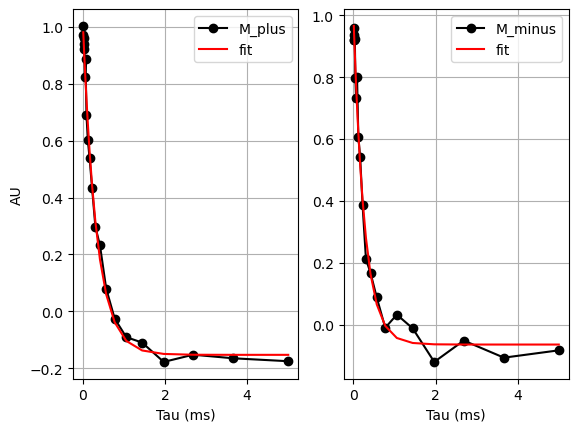

In [80]:
two_meas_t1_plus = pd.read_csv('two_meas_t1_2.914GHz_6dBm_30ns_laser2.25_5ms.csv')
two_meas_t1_minus = pd.read_csv('two_meas_t1_2.828GHz_6dBm_60ns_laser2_5ms.csv')

two_meas_tau_plus = two_meas_t1_plus['M_measured_x'].to_numpy()
M_plus = two_meas_t1_plus['M_measured_y'].to_numpy()

two_meas_tau_minus = two_meas_t1_minus['M_measured_x'].to_numpy()
M_minus = two_meas_t1_minus['M_measured_y'].to_numpy()

two_meas_p0_plus = [M_plus[0], 0, 0]
two_meas_popt_plus, two_meas_pcov_plus = scp.optimize.curve_fit(expfit, two_meas_tau_plus, M_plus, two_meas_p0_plus)

two_meas_p0_minus = [M_minus[0], 0, 0]
two_meas_popt_minus, pcov_minus = scp.optimize.curve_fit(expfit, two_meas_tau_minus, M_minus, two_meas_p0_minus)

T1_Plus_two_meas = 1 / two_meas_popt_plus[1]
T1_Minus_two_meas = 1 / two_meas_popt_minus[1]
Gamma_Plus_two_meas = two_meas_popt_plus[1] * 1000
Gamma_Minus_two_meas = two_meas_popt_minus[1] * 1000

print('T1_Plus (us): ', T1_Plus_two_meas, ' Gamma_Plus (ms^-1): ', Gamma_Plus_two_meas)
print('T1_Minus (us): ', T1_Minus_two_meas, ' Gamma_Minus (ms^-1): ', Gamma_Minus_two_meas)
    
two_meas_fit_plus = expfit(two_meas_tau_plus, two_meas_popt_plus[0], two_meas_popt_plus[1], two_meas_popt_plus[2])
two_meas_fit_minus = expfit(two_meas_tau_minus, two_meas_popt_minus[0], two_meas_popt_minus[1], two_meas_popt_minus[2])

plt.subplot(121)
plt.plot(two_meas_tau_plus / 1000, M_plus, 'o-', color="black", label='M_plus')
plt.plot(two_meas_tau_plus /1000, two_meas_fit_plus, color="red", label='fit')
plt.xlabel('Tau (ms)')
plt.ylabel('AU')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(two_meas_tau_minus / 1000, M_minus, 'o-', color="black", label='M_minus')
plt.plot(two_meas_tau_minus / 1000, two_meas_fit_minus, color="red", label='fit')
plt.xlabel('Tau (ms)')
# plt.ylabel('KiloCounts')
plt.legend()
plt.grid()

plt.show()

T1_Plus (us):  333.3114126833604  Gamma_Plus (ms^-1):  3.000197298824512
T1_Minus (us):  269.6063062792187  Gamma_Minus (ms^-1):  3.7091120523135928


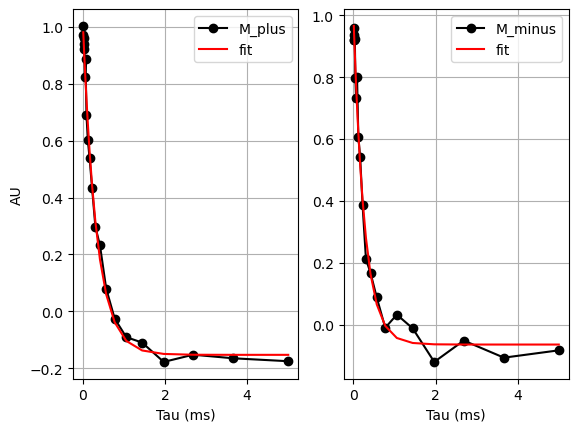

In [82]:
two_meas = pd.read_json('250113/Bayesian T1/Bayesian T1230128final.json')

# S000 = np.array(forced_bayesian['datasets']['S_0_0_0'])
# S00tau = np.array(forced_bayesian['datasets']['S_0_0_tau'])
# Slevel0tau = np.array(forced_bayesian['datasets']['S_level_0_tau'])
# Slevel00 = np.array(forced_bayesian['datasets']['S_level_0_0'])



# forced_Gamma_Minus = np.array(forced_bayesian['datasets']['GammaMinus'])

forced_M_plus = np.array(forced_bayesian['datasets']['M_plus'])
forced_M_plus_err = np.array(forced_bayesian['datasets']['M_plus_err'])

forced_M_minus = np.array(forced_bayesian['datasets']['M_minus'])
forced_M_minus_err = np.array(forced_bayesian['datasets']['M_minus_err'])

two_meas_t1_plus = pd.read_csv('two_meas_t1_2.914GHz_6dBm_30ns_laser2.25_5ms.csv')
two_meas_t1_minus = pd.read_csv('two_meas_t1_2.828GHz_6dBm_60ns_laser2_5ms.csv')

two_meas_tau_plus = two_meas_t1_plus['M_measured_x'].to_numpy()
M_plus = two_meas_t1_plus['M_measured_y'].to_numpy()

two_meas_tau_minus = two_meas_t1_minus['M_measured_x'].to_numpy()
M_minus = two_meas_t1_minus['M_measured_y'].to_numpy()

two_meas_p0_plus = [M_plus[0], 0, 0]
two_meas_popt_plus, two_meas_pcov_plus = scp.optimize.curve_fit(expfit, two_meas_tau_plus, M_plus, two_meas_p0_plus)

two_meas_p0_minus = [M_minus[0], 0, 0]
two_meas_popt_minus, pcov_minus = scp.optimize.curve_fit(expfit, two_meas_tau_minus, M_minus, two_meas_p0_minus)

T1_Plus_two_meas = 1 / two_meas_popt_plus[1]
T1_Minus_two_meas = 1 / two_meas_popt_minus[1]
Gamma_Plus_two_meas = two_meas_popt_plus[1] * 1000
Gamma_Minus_two_meas = two_meas_popt_minus[1] * 1000

print('T1_Plus (us): ', T1_Plus_two_meas, ' Gamma_Plus (ms^-1): ', Gamma_Plus_two_meas)
print('T1_Minus (us): ', T1_Minus_two_meas, ' Gamma_Minus (ms^-1): ', Gamma_Minus_two_meas)
    
two_meas_fit_plus = expfit(two_meas_tau_plus, two_meas_popt_plus[0], two_meas_popt_plus[1], two_meas_popt_plus[2])
two_meas_fit_minus = expfit(two_meas_tau_minus, two_meas_popt_minus[0], two_meas_popt_minus[1], two_meas_popt_minus[2])

plt.subplot(121)
plt.plot(two_meas_tau_plus / 1000, M_plus, 'o-', color="black", label='M_plus')
plt.plot(two_meas_tau_plus /1000, two_meas_fit_plus, color="red", label='fit')
plt.xlabel('Tau (ms)')
plt.ylabel('AU')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(two_meas_tau_minus / 1000, M_minus, 'o-', color="black", label='M_minus')
plt.plot(two_meas_tau_minus / 1000, two_meas_fit_minus, color="red", label='fit')
plt.xlabel('Tau (ms)')
# plt.ylabel('KiloCounts')
plt.legend()
plt.grid()

plt.show()

## Bayesian T1
This methods uses Bayesian inference to find the gammas. Beginning with a flat prior in gamma, optimized taus are calculated and used in experiment. The measurement quantity is then used to calculate the likelihood and update the prior. After several iterations of this, the prior converges to the correct gamma.


--- Forcing taus: tau optimization is turned off and I manually feed the tau values around the point where I expect the most optial tau would be.

In [28]:
tau_forced = [
    0.343, 
    0.252,
    0.132,
    0.472,
    0.178,
    0.187,
    0.233,
    0.417,
    0.114,
    0.141,
    0.086,
    0.5,
    0.454,
    0.123,
    0.389,
    0.371,
    0.215,
    0.444,
    0.307,
    0.151,
    0.05,
    0.325,
    0.261,
    0.408,
    0.068,
    0.206,
    0.288,
    0.242,
    0.481,
    0.316,
    0.279,
    0.297,
    0.435,
    0.27,
    0.353,
    0.196,
    0.105,
    0.160,
    0.224,
    0.169,
    0.362,
    0.077,
    0.380,
    0.095,
    0.463,
    0.426,
    0.398,
    0.059,
    0.334,
    0.49
]

In [5]:
forced_bayesian = pd.read_json('C://Users/awschlab/Desktop/data/250113/Bayesian T1/Bayesian T1230128final.json')

forced_Gamma_Plus = np.array(forced_bayesian['datasets']['GammaPlus'])
forced_Gamma_Minus = np.array(forced_bayesian['datasets']['GammaMinus'])

forced_M_plus = np.array(forced_bayesian['datasets']['M_plus'])
forced_M_plus_err = np.array(forced_bayesian['datasets']['M_plus_err'])

forced_M_minus = np.array(forced_bayesian['datasets']['M_minus'])
forced_M_minus_err = np.array(forced_bayesian['datasets']['M_minus_err'])

forced_tau = np.array(tau_forced)
indices = np.argsort(forced_tau)

# arranging the taus and measured quantities in ascending order
forced_final_tau = np.array([forced_tau[i] for i in indices])

forced_final_M_plus = [forced_M_plus[i] for i in indices]
forced_final_M_plus_err = [forced_M_plus_err[i] for i in indices]

forced_final_M_minus = [forced_M_minus[i] for i in indices]
forced_final_M_minus_err = [forced_M_minus_err[i] for i in indices]

forced_p0_plus = [forced_M_plus[0], 0, 0]
forced_popt_plus, forced_pcov_plus = scp.optimize.curve_fit(expfit, forced_final_tau, forced_final_M_plus, forced_p0_plus)

forced_p0_minus = [forced_M_minus[0], 0, 0]
forced_popt_minus, forced_pcov_minus = scp.optimize.curve_fit(expfit, forced_final_tau, forced_final_M_minus, forced_p0_minus)

T1_Plus_forced = 1000 / forced_popt_plus[1]
T1_Minus_forced = 1000 / forced_popt_minus[1]
Gamma_Plus_forced = forced_popt_plus[1] 
Gamma_Minus_forced = forced_popt_minus[1]

print('FITTED')
print('T1_Plus (us): ', T1_Plus_forced, ' Gamma_Plus (ms^-1): ', Gamma_Plus_forced)
print('T1_Minus (us): ', T1_Minus_forced, ' Gamma_Minus (ms^-1): ', Gamma_Minus_forced)

print('PREDICTED')
print('T1_Plus (us): ', 1000 / forced_Gamma_Plus[49], ' Gamma_Plus (ms^-1): ', forced_Gamma_Plus[49])
print('T1_Plus (us): ', 1000 / forced_Gamma_Minus[49], ' Gamma_Plus (ms^-1): ', forced_Gamma_Minus[49])
    
forced_fit_plus = expfit(forced_final_tau, forced_popt_plus[0], forced_popt_plus[1], forced_popt_plus[2])
forced_fit_minus = expfit(forced_final_tau, forced_popt_minus[0], forced_popt_minus[1], forced_popt_minus[2])

plt.subplot(121)
plt.errorbar(forced_final_tau, forced_final_M_plus, yerr = forced_final_M_plus_err, ls = 'none', color = 'black', capsize = 2)
plt.plot(forced_final_tau, forced_final_M_plus, 'o', color = 'black', label = 'M_plus')
plt.plot(forced_final_tau, forced_fit_plus, color="red", label='fit')
# plt.xscale('log')
plt.xlabel('Tau (ms)')
plt.ylabel('AU')
plt.legend()

plt.subplot(122)
plt.errorbar(forced_final_tau, forced_final_M_minus, yerr = forced_final_M_minus_err, ls = 'none', color = 'black', capsize = 2)
plt.plot(forced_final_tau, forced_final_M_minus, 'o', color = 'black', label = 'M_minus')
plt.plot(forced_final_tau, forced_fit_minus, color="red", label='fit')
# plt.xscale('log')
plt.xlabel('Tau (ms)')
# plt.ylabel('M_minus (AU)')
plt.legend()

plt.show()

ImportError: Missing optional dependency 'fsspec'.  Use pip or conda to install fsspec.